In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pandas as pd
import numpy as np

sys.path.append('./..')
sys.path.append('./../..')
import torch
import math
import yaml
from sklearn.metrics import auc
from tqdm import tqdm
from collections import OrderedDict
from matplotlib import pyplot as plt
from pathlib import Path
import argparse
import multiprocessing
from pprint import pprint
from time import time
from datetime import datetime
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)
# ===============================================
try:
    from data_fetcher import data_fetcher
except:
    from .data_fetcher import data_fetcher
try:
    from model_aef_r import model_FAER_container as Model
except:
    from .model_aef_r import model_FAER_container as Model
try:
    from utils import create_config
except:
    from .utils import create_config
try:
    import utils
except:
    from . import utils

Current device  >>  cuda
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Current device  >>  cuda


In [31]:
DATA_SET = 'nb15'

In [32]:
encoder_structure_config, decoder_structure_config, loss_structure_config, latent_dim = create_config(DATA_SET)
anomaly_ratio = -1
ae_model = None
if DATA_SET == 'kddcup':
    anomaly_ratio = 0.2
    ae_model = Model(
        DEVICE,
        latent_dim,
        encoder_structure_config,
        decoder_structure_config,
        loss_structure_config,
        optimizer='Adam',
        batch_size=256,
        num_epochs=25,
        learning_rate=0.05,
    )
elif DATA_SET == 'kddcup_neptune':
    anomaly_ratio = 0.2
    ae_model = Model(
        DEVICE,
        latent_dim,
        encoder_structure_config,
        decoder_structure_config,
        loss_structure_config,
        optimizer='Adam',
        batch_size=256,
        num_epochs=25,
        learning_rate=0.001,
        
    )


elif DATA_SET == 'nsl_kdd':
    anomaly_ratio = 0.1
    ae_model = Model(
        DEVICE,
        latent_dim,
        encoder_structure_config,
        decoder_structure_config,
        loss_structure_config,
        optimizer='Adam',
        batch_size=256,
        num_epochs=20,
        learning_rate=0.0005,
    )

elif DATA_SET == 'nb15':
    anomaly_ratio = 0.1
    ae_model = Model(
        DEVICE,
        latent_dim,
        encoder_structure_config,
        decoder_structure_config,
        loss_structure_config,
        optimizer='Adam',
        batch_size=128,
        num_epochs=25,
        learning_rate=0.001,
        
    )

Size:  train_df 39200 , test_df 16800, anomaly data 5009, Req anomalies 3360
split schema  [133, 11, 9, 3, 1, 37]
Loss structure config {'discrete_dims': OrderedDict([('proto', 133), ('service', 11), ('state', 9), ('is_ftp_login', 3), ('is_sm_ips_ports', 2)]), 'real_loss_func': 'smooth_l1', 'real_dims': 37}
 Loss module split schema  [133, 11, 9, 3, 1, 37]


In [33]:
print(ae_model.network_module)

model_FAER(
  (ae_module): AE(
    (encoder): AE_encoder(
      (input_x_form_layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=133, out_features=10, bias=True)
          (1): Identity()
        )
        (1): Identity()
        (2): Identity()
        (3): Identity()
        (4): Identity()
        (5): Sequential(
          (0): Linear(in_features=37, out_features=16, bias=True)
          (1): Tanh()
        )
      )
      (FC_z): Sequential(
        (0): Linear(in_features=50, out_features=32, bias=True)
        (1): Dropout(p=0.1, inplace=False)
        (2): Tanh()
        (3): Linear(in_features=32, out_features=16, bias=True)
        (4): Dropout(p=0.1, inplace=False)
        (5): Tanh()
        (6): Linear(in_features=16, out_features=8, bias=True)
        (7): Dropout(p=0.1, inplace=False)
        (8): Tanh()
      )
    )
    (decoder): AE_decoder(
      (FC_z): Sequential(
        (0): Linear(in_features=8, out_features=16, bias=True)
        (1

In [34]:
num_anomaly_sets = 5
data_dict, _ = data_fetcher.get_data(
    DATA_SET,
    one_hot=True,
    num_anom_sets= num_anomaly_sets,
    anomaly_ratio= anomaly_ratio
)

train_df = data_dict['train']
train_X = train_df.values

Size:  train_df 39200 , test_df 16800, anomaly data 5009, Req anomalies 1680


In [35]:
losses = ae_model.train_model(
    train_X
)

  0%|          | 0/25 [00:00<?, ?it/s]

 Epoch 1 Batch 0 Loss 155.0358 
 Epoch 1 Batch 100 Loss 113.7062 
 Epoch 1 Batch 200 Loss 109.6203 


  4%|▍         | 1/25 [00:02<00:53,  2.23s/it]

 Epoch 1 Batch 300 Loss 109.2864 
Epoch loss :: 117.9725
 Epoch 2 Batch 0 Loss 109.2134 
 Epoch 2 Batch 100 Loss 109.1133 
 Epoch 2 Batch 200 Loss 109.0399 


  8%|▊         | 2/25 [00:04<00:48,  2.13s/it]

 Epoch 2 Batch 300 Loss 109.1054 
Epoch loss :: 109.043976
 Epoch 3 Batch 0 Loss 108.9168 
 Epoch 3 Batch 100 Loss 108.8947 
 Epoch 3 Batch 200 Loss 108.7567 


 12%|█▏        | 3/25 [00:06<00:46,  2.09s/it]

 Epoch 3 Batch 300 Loss 108.8892 
Epoch loss :: 108.94292
 Epoch 4 Batch 0 Loss 108.9003 
 Epoch 4 Batch 100 Loss 108.8741 
 Epoch 4 Batch 200 Loss 108.9069 


 16%|█▌        | 4/25 [00:08<00:42,  2.03s/it]

 Epoch 4 Batch 300 Loss 108.9130 
Epoch loss :: 108.91017
 Epoch 5 Batch 0 Loss 108.9331 
 Epoch 5 Batch 100 Loss 108.8823 
 Epoch 5 Batch 200 Loss 108.9312 


 20%|██        | 5/25 [00:10<00:43,  2.18s/it]

 Epoch 5 Batch 300 Loss 108.9279 
Epoch loss :: 108.894775
 Epoch 6 Batch 0 Loss 108.7848 
 Epoch 6 Batch 100 Loss 108.9308 
 Epoch 6 Batch 200 Loss 108.9332 


 24%|██▍       | 6/25 [00:12<00:41,  2.17s/it]

 Epoch 6 Batch 300 Loss 108.8020 
Epoch loss :: 108.886284
 Epoch 7 Batch 0 Loss 108.8567 
 Epoch 7 Batch 100 Loss 108.9546 
 Epoch 7 Batch 200 Loss 108.8566 


 28%|██▊       | 7/25 [00:14<00:38,  2.12s/it]

 Epoch 7 Batch 300 Loss 108.9976 
Epoch loss :: 108.88022
 Epoch 8 Batch 0 Loss 108.9653 
 Epoch 8 Batch 100 Loss 108.9485 
 Epoch 8 Batch 200 Loss 108.9078 


 32%|███▏      | 8/25 [00:16<00:35,  2.10s/it]

 Epoch 8 Batch 300 Loss 108.8239 
Epoch loss :: 108.877815
 Epoch 9 Batch 0 Loss 108.9087 
 Epoch 9 Batch 100 Loss 108.8328 
 Epoch 9 Batch 200 Loss 108.7701 


 36%|███▌      | 9/25 [00:18<00:33,  2.09s/it]

 Epoch 9 Batch 300 Loss 108.8347 
Epoch loss :: 108.874596
 Epoch 10 Batch 0 Loss 108.8971 
 Epoch 10 Batch 100 Loss 108.8688 
 Epoch 10 Batch 200 Loss 108.9147 


 40%|████      | 10/25 [00:21<00:32,  2.14s/it]

 Epoch 10 Batch 300 Loss 108.8724 
Epoch loss :: 108.87207
 Epoch 11 Batch 0 Loss 108.8784 
 Epoch 11 Batch 100 Loss 108.7905 
 Epoch 11 Batch 200 Loss 108.8564 


 44%|████▍     | 11/25 [00:23<00:29,  2.11s/it]

 Epoch 11 Batch 300 Loss 108.9507 
Epoch loss :: 108.87062
 Epoch 12 Batch 0 Loss 108.8856 
 Epoch 12 Batch 100 Loss 109.0498 
 Epoch 12 Batch 200 Loss 108.9250 


 48%|████▊     | 12/25 [00:25<00:27,  2.10s/it]

 Epoch 12 Batch 300 Loss 108.8308 
Epoch loss :: 108.86955
 Epoch 13 Batch 0 Loss 108.9158 
 Epoch 13 Batch 100 Loss 108.7862 
 Epoch 13 Batch 200 Loss 108.7710 


 52%|█████▏    | 13/25 [00:27<00:25,  2.13s/it]

 Epoch 13 Batch 300 Loss 108.7574 
Epoch loss :: 108.86944
 Epoch 14 Batch 0 Loss 108.8092 
 Epoch 14 Batch 100 Loss 108.9166 
 Epoch 14 Batch 200 Loss 108.8801 


 56%|█████▌    | 14/25 [00:29<00:22,  2.07s/it]

 Epoch 14 Batch 300 Loss 108.8718 
Epoch loss :: 108.86907
 Epoch 15 Batch 0 Loss 108.9248 
 Epoch 15 Batch 100 Loss 108.7727 
 Epoch 15 Batch 200 Loss 108.8631 


 60%|██████    | 15/25 [00:31<00:20,  2.01s/it]

 Epoch 15 Batch 300 Loss 108.8158 
Epoch loss :: 108.868484
 Epoch 16 Batch 0 Loss 108.8454 
 Epoch 16 Batch 100 Loss 108.7874 
 Epoch 16 Batch 200 Loss 108.9411 


 64%|██████▍   | 16/25 [00:33<00:17,  1.96s/it]

 Epoch 16 Batch 300 Loss 109.0242 
Epoch loss :: 108.867546
 Epoch 17 Batch 0 Loss 108.7530 
 Epoch 17 Batch 100 Loss 108.8025 
 Epoch 17 Batch 200 Loss 108.7910 


 68%|██████▊   | 17/25 [00:34<00:15,  1.93s/it]

 Epoch 17 Batch 300 Loss 108.9432 
Epoch loss :: 108.867226
 Epoch 18 Batch 0 Loss 109.0247 
 Epoch 18 Batch 100 Loss 108.8996 
 Epoch 18 Batch 200 Loss 108.9381 


 72%|███████▏  | 18/25 [00:36<00:13,  1.91s/it]

 Epoch 18 Batch 300 Loss 108.7816 
Epoch loss :: 108.867035
 Epoch 19 Batch 0 Loss 108.9873 
 Epoch 19 Batch 100 Loss 108.8891 
 Epoch 19 Batch 200 Loss 108.7691 


 76%|███████▌  | 19/25 [00:38<00:11,  1.90s/it]

 Epoch 19 Batch 300 Loss 108.8180 
Epoch loss :: 108.866905
 Epoch 20 Batch 0 Loss 108.8675 
 Epoch 20 Batch 100 Loss 108.8716 
 Epoch 20 Batch 200 Loss 108.7686 


 80%|████████  | 20/25 [00:40<00:09,  1.89s/it]

 Epoch 20 Batch 300 Loss 108.8771 
Epoch loss :: 108.86627
 Epoch 21 Batch 0 Loss 108.8608 
 Epoch 21 Batch 100 Loss 108.9034 
 Epoch 21 Batch 200 Loss 108.9127 


 84%|████████▍ | 21/25 [00:42<00:07,  1.88s/it]

 Epoch 21 Batch 300 Loss 108.9304 
Epoch loss :: 108.86637
 Epoch 22 Batch 0 Loss 108.8765 
 Epoch 22 Batch 100 Loss 108.8447 
 Epoch 22 Batch 200 Loss 108.8958 


 88%|████████▊ | 22/25 [00:44<00:05,  1.87s/it]

 Epoch 22 Batch 300 Loss 108.9000 
Epoch loss :: 108.86589
 Epoch 23 Batch 0 Loss 108.9900 
 Epoch 23 Batch 100 Loss 108.8200 
 Epoch 23 Batch 200 Loss 108.8591 


 92%|█████████▏| 23/25 [00:46<00:03,  1.87s/it]

 Epoch 23 Batch 300 Loss 108.8000 
Epoch loss :: 108.86738
 Epoch 24 Batch 0 Loss 108.9961 
 Epoch 24 Batch 100 Loss 109.1121 
 Epoch 24 Batch 200 Loss 108.7776 


 96%|█████████▌| 24/25 [00:48<00:01,  1.91s/it]

 Epoch 24 Batch 300 Loss 108.8076 
Epoch loss :: 108.86566
 Epoch 25 Batch 0 Loss 108.8712 
 Epoch 25 Batch 100 Loss 108.8047 
 Epoch 25 Batch 200 Loss 108.7727 


100%|██████████| 25/25 [00:50<00:00,  2.01s/it]

 Epoch 25 Batch 300 Loss 108.9819 
Epoch loss :: 108.86641


0.99 0.19033862943347776 0.705952380952381 6231 1186
0.98 0.19033862943347776 0.705952380952381 6231 1186
0.97 0.19033862943347776 0.705952380952381 6231 1186
0.96 0.19033862943347776 0.705952380952381 6231 1186
0.95 0.19033862943347776 0.705952380952381 6231 1186
0.94 0.19033862943347776 0.705952380952381 6231 1186
0.93 0.19033862943347776 0.705952380952381 6231 1186
0.92 0.19033862943347776 0.705952380952381 6231 1186
0.91 0.19033862943347776 0.705952380952381 6231 1186
0.9 0.19033862943347776 0.705952380952381 6231 1186
0.89 0.19033862943347776 0.705952380952381 6231 1186
0.88 0.19033862943347776 0.705952380952381 6231 1186
0.87 0.19033862943347776 0.705952380952381 6231 1186
0.86 0.19033862943347776 0.705952380952381 6231 1186
0.85 0.19033862943347776 0.705952380952381 6231 1186
0.84 0.19033862943347776 0.705952380952381 6231 1186
0.83 0.19033862943347776 0.705952380952381 6231 1186
0.82 0.19033862943347776 0.705952380952381 6231 1186
0.81 0.19033862943347776 0.705952380952381 6231

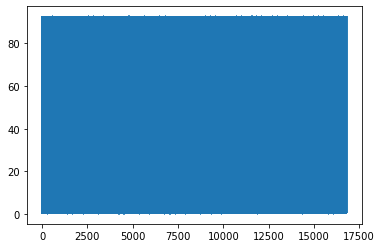

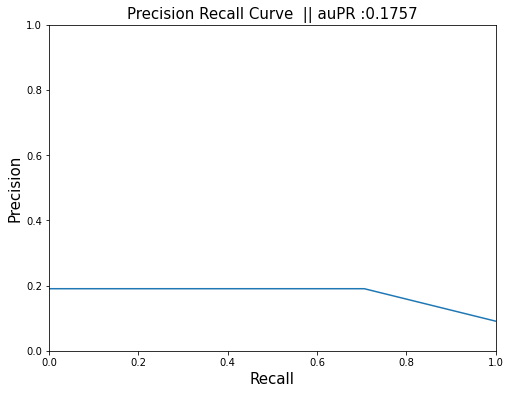

AUC : 0.1757 
0.99 0.18405304868186964 0.6773809523809524 6183 1138
0.98 0.18405304868186964 0.6773809523809524 6183 1138
0.97 0.18405304868186964 0.6773809523809524 6183 1138
0.96 0.18405304868186964 0.6773809523809524 6183 1138
0.95 0.18405304868186964 0.6773809523809524 6183 1138
0.94 0.18405304868186964 0.6773809523809524 6183 1138
0.93 0.18405304868186964 0.6773809523809524 6183 1138
0.92 0.18405304868186964 0.6773809523809524 6183 1138
0.91 0.18405304868186964 0.6773809523809524 6183 1138
0.9 0.18405304868186964 0.6773809523809524 6183 1138
0.89 0.18405304868186964 0.6773809523809524 6183 1138
0.88 0.18405304868186964 0.6773809523809524 6183 1138
0.87 0.18405304868186964 0.6773809523809524 6183 1138
0.86 0.18405304868186964 0.6773809523809524 6183 1138
0.85 0.18405304868186964 0.6773809523809524 6183 1138
0.84 0.18405304868186964 0.6773809523809524 6183 1138
0.83 0.18405304868186964 0.6773809523809524 6183 1138
0.82 0.18405304868186964 0.6773809523809524 6183 1138
0.81 0.18405304

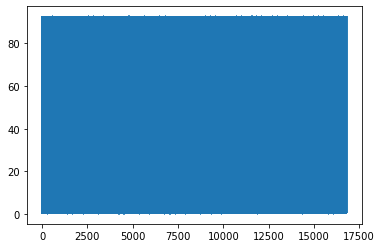

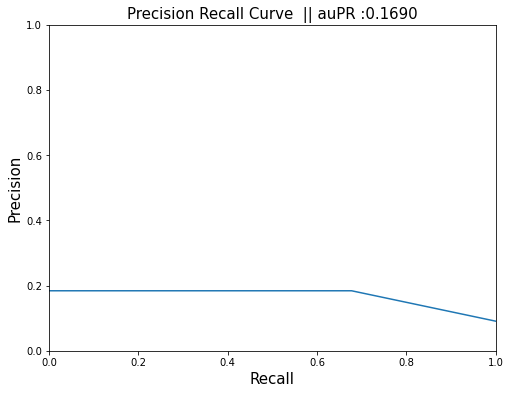

AUC : 0.1690 
0.99 0.18629032258064515 0.6875 6200 1155
0.98 0.18629032258064515 0.6875 6200 1155
0.97 0.18629032258064515 0.6875 6200 1155
0.96 0.18629032258064515 0.6875 6200 1155
0.95 0.18629032258064515 0.6875 6200 1155
0.94 0.18629032258064515 0.6875 6200 1155
0.93 0.18629032258064515 0.6875 6200 1155
0.92 0.18629032258064515 0.6875 6200 1155
0.91 0.18629032258064515 0.6875 6200 1155
0.9 0.18629032258064515 0.6875 6200 1155
0.89 0.18629032258064515 0.6875 6200 1155
0.88 0.18629032258064515 0.6875 6200 1155
0.87 0.18629032258064515 0.6875 6200 1155
0.86 0.18629032258064515 0.6875 6200 1155
0.85 0.18629032258064515 0.6875 6200 1155
0.84 0.18629032258064515 0.6875 6200 1155
0.83 0.18629032258064515 0.6875 6200 1155
0.82 0.18629032258064515 0.6875 6200 1155
0.81 0.18629032258064515 0.6875 6200 1155
0.8 0.18629032258064515 0.6875 6200 1155
0.79 0.18629032258064515 0.6875 6200 1155
0.78 0.18629032258064515 0.6875 6200 1155
0.77 0.18629032258064515 0.6875 6200 1155
0.76 0.186290322580645

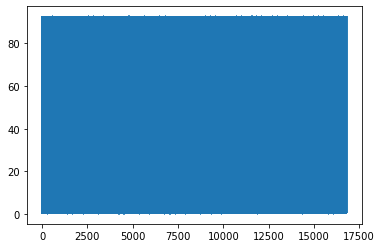

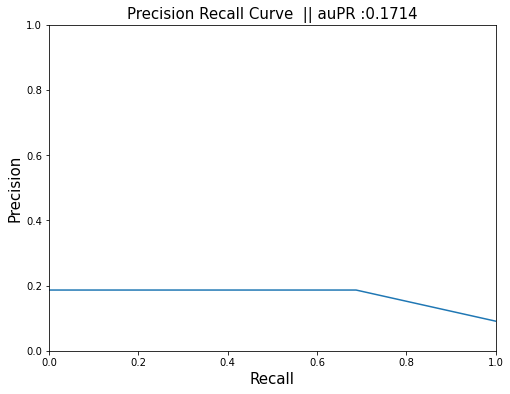

AUC : 0.1714 
0.99 0.19267082733237317 0.7166666666666667 6249 1204
0.98 0.19267082733237317 0.7166666666666667 6249 1204
0.97 0.19267082733237317 0.7166666666666667 6249 1204
0.96 0.19267082733237317 0.7166666666666667 6249 1204
0.95 0.19267082733237317 0.7166666666666667 6249 1204
0.94 0.19267082733237317 0.7166666666666667 6249 1204
0.93 0.19267082733237317 0.7166666666666667 6249 1204
0.92 0.19267082733237317 0.7166666666666667 6249 1204
0.91 0.19267082733237317 0.7166666666666667 6249 1204
0.9 0.19267082733237317 0.7166666666666667 6249 1204
0.89 0.19267082733237317 0.7166666666666667 6249 1204
0.88 0.19267082733237317 0.7166666666666667 6249 1204
0.87 0.19267082733237317 0.7166666666666667 6249 1204
0.86 0.19267082733237317 0.7166666666666667 6249 1204
0.85 0.19267082733237317 0.7166666666666667 6249 1204
0.84 0.19267082733237317 0.7166666666666667 6249 1204
0.83 0.19267082733237317 0.7166666666666667 6249 1204
0.82 0.19267082733237317 0.7166666666666667 6249 1204
0.81 0.19267082

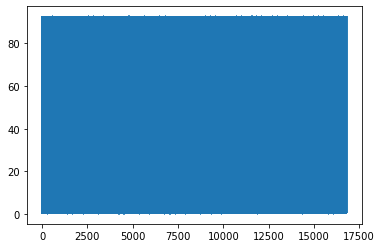

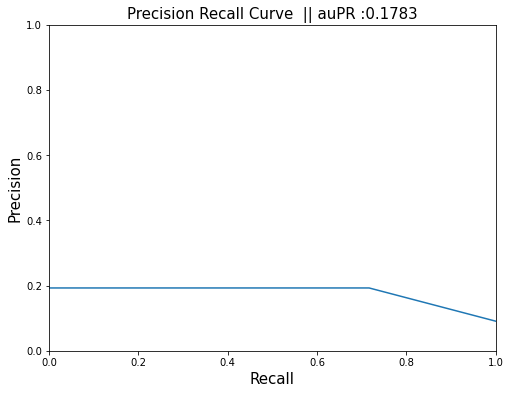

AUC : 0.1783 


In [ ]:
test_norm_df = data_dict['test']
test_norm_X = test_norm_df.values

auc_list = []
ae_model.mode = 'test'

def _normalize_(val, _min, _max):
    return (val - _min) / (_max - _min)

for idx in range(1, num_anomaly_sets + 1):
    key = 'anom_' + str(idx)
    test_anom_df = data_dict[key]
    test_anom_X = test_anom_df.values
    x1 = test_norm_X
    x2 = test_anom_X

    x1_scores = ae_model.get_score(x1)
    x2_scores = ae_model.get_score(x2)
    
    
    plt.violinplot(x1_scores)
    
    
    res_data = []
    labels = [1 for _ in range(x1.shape[0])] + [0 for _ in range(x2.shape[0])]
    _scores = np.concatenate([x1_scores, x2_scores], axis=0)
    for i, j in zip(_scores, labels):
        res_data.append((i[0], j))

    res_df = pd.DataFrame(res_data, columns=['score', 'label'])
    res_df = res_df.sort_values(by=['score'], ascending=False)

    _max = max(res_df['score'])
    _min = min(res_df['score'])

    res_df['score'] = res_df['score'].parallel_apply(
        _normalize_,
        args=(_min, _max,)
    )
   
    _max = max(res_df['score'])
    _min = min(res_df['score'])

    step = (_max - _min) / 100

    # Vary the threshold
    thresh = _max - step
    thresh = round(thresh, 3)
    num_anomalies = x2.shape[0]
    P = []
    R = [0]
    while thresh >= _min :
        sel = res_df.loc[res_df['score'] >= thresh]
        if len(sel) == 0:
            thresh -= step
            continue

        correct = sel.loc[sel['label'] == 0]

        prec = len(correct) / len(sel)
        rec = len(correct) / num_anomalies
        print(thresh,prec,rec,  len(sel), len(correct))
        P.append(prec)
        R.append(rec)
        thresh -= step
        thresh = round(thresh, 3)

    P = [P[0]] + P
    pr_auc = auc(R, P)
    try:
        plt.figure(figsize=[8, 6])
        plt.xlim([0.0,1.0])
        plt.ylim([0.0,1.0])
        plt.plot(R, P)
        plt.title('Precision Recall Curve  || auPR :' + "{:0.4f}".format(pr_auc), fontsize=15)
        plt.xlabel('Recall', fontsize=15)
        plt.ylabel('Precision', fontsize=15)
        plt.show()
    except:
        pass
    print("AUC : {:0.4f} ".format(pr_auc))
    auc_list.append(pr_auc)
_mean = np.mean(auc_list)
_std = np.std(auc_list)
print(' Mean AUC {:0.4f} '.format(_mean))
print(' AUC std {:0.4f} '.format(_std))